<a href="https://colab.research.google.com/github/rohitrrg/Face_Mask_Detection-YOLOv5/blob/main/Face_Mask_Detection_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup the Environment
We are going to use YOLOv5 model for training.
so lets clone and install the YOLO from github repo <br>

<br>YOLOv5 rocket is a family of object detection architectures and models pretrained on the COCO dataset, and represents Ultralytics open-source research into future vision AI methods, incorporating lessons learned and best practices evolved over thousands of hours of research and development. <br>
See the YOLOv5 Docs for full documentation on training, testing and deployment.[https://docs.ultralytics.com/](http://)

In [ ]:
from google.colab import files
files.upload()

In [2]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import clear_output

warnings.filterwarnings('ignore')

In [4]:
!kaggle datasets download -d andrewmvd/face-mask-detection

 95% 379M/398M [00:02<00:00, 229MB/s]
100% 398M/398M [00:02<00:00, 166MB/s]


In [5]:
! unzip -q face-mask-detection.zip
! rm face-mask-detection.zip

In [6]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

clear_output()

# Read and Handle Annotations
Read the data from .xml files
<br>
Extract filename and dimensions of the bouding boxes
<br>
and import that data into a pandas DataFrame

In [7]:
path = '/content/'
annotations_path = "/content/annotations/"
images_path = "/content/images/"

In [8]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

for anno in glob.glob(annotations_path+"*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [9]:
df=pd.DataFrame(dataset)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax
0,maksssksksss66,with_mask,380,400,179,81,267,173
1,maksssksksss539,with_mask,400,267,25,13,35,25
2,maksssksksss539,with_mask,400,267,55,10,65,20
3,maksssksksss539,with_mask,400,267,120,16,130,31
4,maksssksksss539,with_mask,400,267,167,3,178,15


In [10]:
df['name'].value_counts()

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: name, dtype: int64

In [11]:
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

df['class'] = df['name'].map(name_dict)

In [12]:
def show_boxes(name):
    img = name+'.png'
    img = cv2.imread(images_path+img)
    for i in df[df['file']==name].iterrows():
        x1, x2, y1, y2 = i[1]['xmin'],i[1]['xmax'],i[1]['ymin'],i[1]['ymax']
        if i[1]['name']=='with_mask':
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        else:
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    plt.imshow(img)

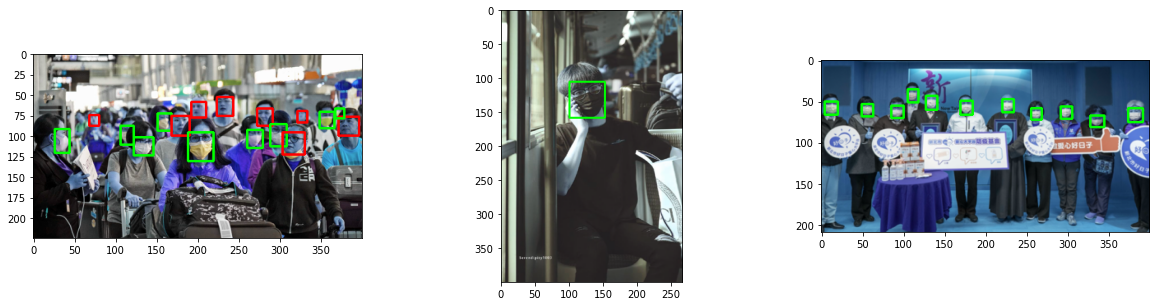

In [13]:
plt.figure(figsize=(20,5))
for i, img in enumerate(random.sample(set(df['file']), 3), start=1):
    plt.subplot(1,3,i)
    show_boxes(img)

# Train Test Split
Split the dataset into training testing and validation set
<br>
separate the data in different folder inside the Yolo directory
<br>
and Normalize data

In [14]:
fileNames = [*os.listdir(images_path)]
print('There are {} images in the dataset'.format(len(fileNames)))

There are 853 images in the dataset


In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fileNames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("="*30)
print("Length of Valid =",len(val))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of Valid = 61
Length of test = 25


In [16]:
# create separate train test and validation dir inside yolo/data/
os.chdir(path)
os.mkdir('./yolov5/data/train')
os.mkdir('./yolov5/data/val')
os.mkdir('./yolov5/data/test')
os.mkdir('./yolov5/data/train/images')
os.mkdir('./yolov5/data/train/labels')
os.mkdir('./yolov5/data/test/images')
os.mkdir('./yolov5/data/test/labels')
os.mkdir('./yolov5/data/val/images')
os.mkdir('./yolov5/data/val/labels')

In [17]:
from tqdm import tqdm
from PIL import Image

def copyImages(imageList, folder_Name):
    for image in tqdm(imageList):
        img = Image.open(path+"images/"+image)
        img1 = img.resize((640, 480))
        _ = img1.save(path+"yolov5/data/"+folder_Name+"/images/"+image)

copyImages(train, "train")
copyImages(val, "val")
copyImages(test, "test")

100%|██████████| 25/25 [00:04<00:00,  5.83it/s]


In [18]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss66,with_mask,380,400,179,81,267,173,0
1,maksssksksss539,with_mask,400,267,25,13,35,25,0
2,maksssksksss539,with_mask,400,267,55,10,65,20,0
3,maksssksksss539,with_mask,400,267,120,16,130,31,0
4,maksssksksss539,with_mask,400,267,167,3,178,15,0


In [19]:
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

In [20]:
df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [21]:
df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

In [22]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_height,box_width
0,maksssksksss66,with_mask,380,400,301,97,449,207,0,0.585938,0.316667,0.231250,0.229167
1,maksssksksss539,with_mask,400,267,40,23,56,44,0,0.075000,0.069792,0.025000,0.043750
2,maksssksksss539,with_mask,400,267,88,17,104,35,0,0.150000,0.054167,0.025000,0.037500
3,maksssksksss539,with_mask,400,267,192,28,208,55,0,0.312500,0.086458,0.025000,0.056250
4,maksssksksss539,with_mask,400,267,267,5,284,26,0,0.430469,0.032292,0.026562,0.043750


In [23]:
df = df.astype('string')

In [24]:
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])
            
        text = "\n".join(box_list)
        with open(path+"yolov5/data/"+data_name+"/labels/"+name+".txt", "w") as file:
            file.write(text)


create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

# Configure the Model

In [25]:
# go to YOLO directory
%cd yolov5

/content/yolov5


In [26]:
# configure .yaml file to guide the model for training
yaml_text = """train: data/train/images
val: data/val/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml

train: data/train/images
val: data/val/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

In [27]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [28]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

# Train the Model

In [ ]:
### train yolov5s on custom data for 100 epochs
# time its performance
# we are going to using pre-trained weights from yolov5.pt model

start = datetime.now()
!python train.py --img 640 --batch 16 --epochs 100 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache
end = datetime.now()

In [30]:
print("Runtime =",end-start)

Runtime = 0:24:37.704700


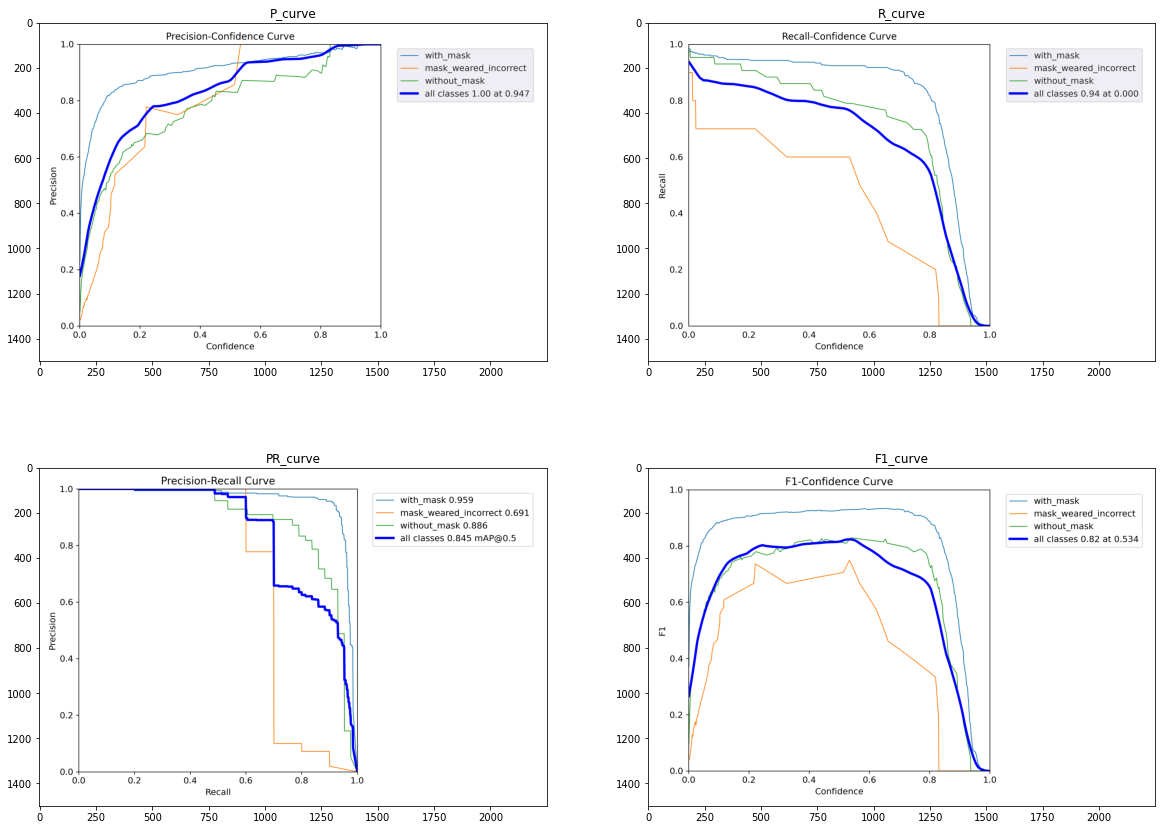

In [47]:
ev = ['P_curve','R_curve','PR_curve','F1_curve']
plt.figure(figsize=(20,15))
for i, c in enumerate(ev, start=1):
    plt.subplot(2,2,i)
    img = plt.imread('runs/train/yolov5s_results/'+c+'.png')
    plt.title(c)
    plt.imshow(img)

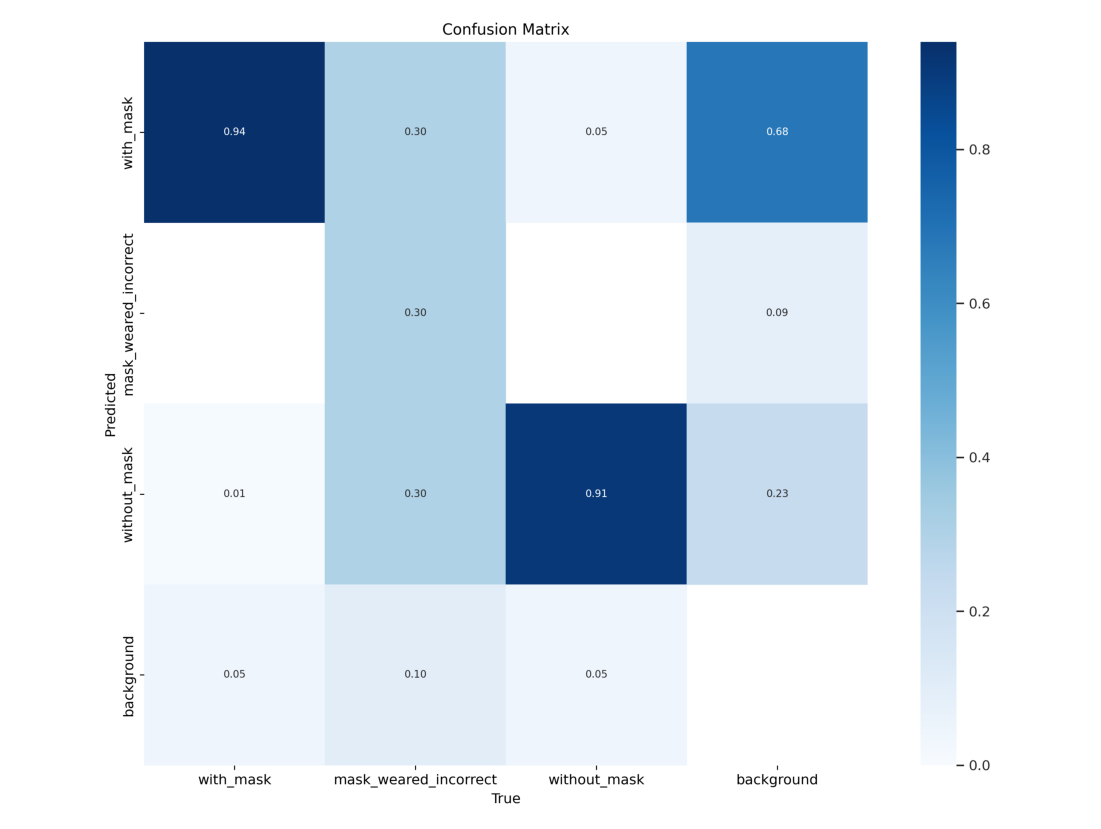

In [34]:

# lets visualize the training results
img = plt.imread('runs/train/yolov5s_results/confusion_matrix.png')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

# Test the Model
lets test the model over test images we had separated before training

In [ ]:
!python detect.py --source data/test/images/ --weights runs/train/yolov5s_results/weights/best.pt --name expTestImage --conf 0.4 --hide-labels

In [36]:
color_dict = {
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect':  (0, 0, 255),
    'without_mask': (255, 0, 0) 
}

In [39]:
def show_image(img_id):
    df_image = df[df.file==img_id.split('.')[0]]
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = 'data/test/images/'+img_id# +'.png'
    img = plt.imread(path)

    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)

    img_pred = plt.imread('runs/detect/expTestImage/'+img_id)
    # ===================================
    plt.figure(figsize=(14,17))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Image with Truth Box')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')

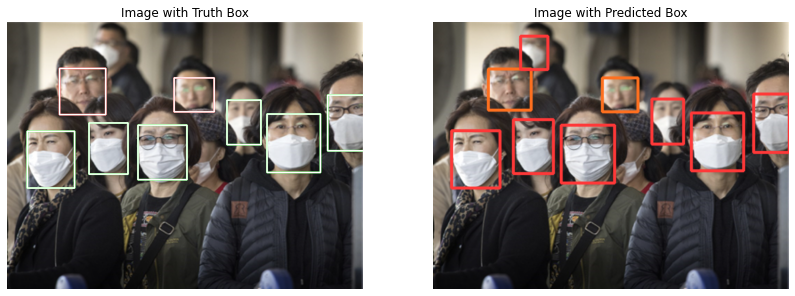

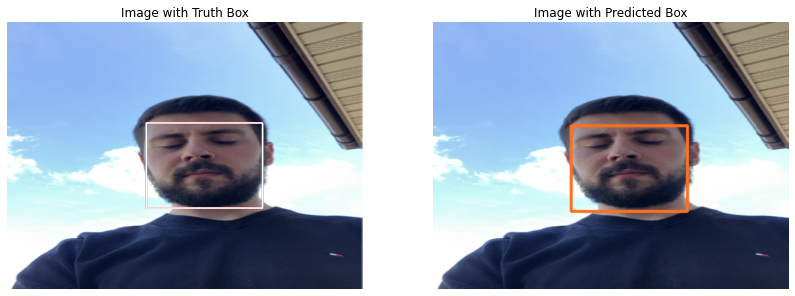

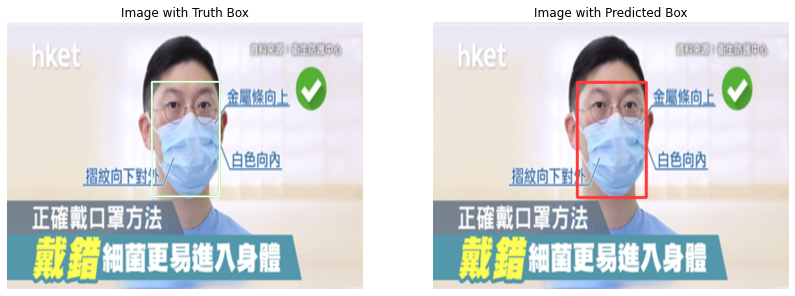

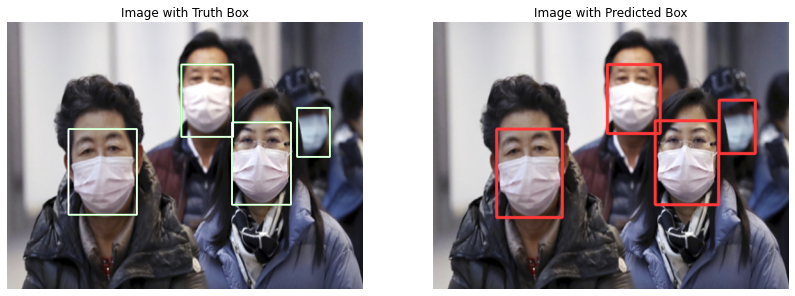

In [48]:
import os, random
show_image(random.choice(os.listdir("data/test/images/"))) 
show_image(random.choice(os.listdir("data/test/images/"))) 
show_image(random.choice(os.listdir("data/test/images/"))) 
show_image(random.choice(os.listdir("data/test/images/"))) 
plt.show()